In [1]:
import os
import yaml

import torch
import pandas as pd
import matplotlib.pyplot as plt

from xopt import Xopt
from lume_model.utils import variables_from_yaml
from lume_model.torch import PyTorchModel, LUMEModule

## Load Data from BO and BE Runs

In [2]:
data_dir = "/home/physics3/ml_tuning/"

bo_files = [
    # "../optimization/optimization_results.yml",
    # data_dir + "20230818_LCLS_optimize/nn_optimization.yml",
    # data_dir + "20230821_LCLS_Injector/normal_optimization.yml",
    # data_dir + "20230821_LCLS_Injector/nn_optimization.yml",
    # data_dir + "20230821_LCLS_Injector/turbo_optimization.yml",
    # data_dir + "20230821_LCLS_Injector/turbo_optimization_2.yml",
    # data_dir + "20230821_LCLS_Injector/turbo_optimization_3.yml",
    
    data_dir + "20230825_LCLS_Injector/nn_optimization.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_1.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_vanilla.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_cal_high_reg.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_cal_high_reg_adj_bounds.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_cal_low_reg_adj_bounds.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_cal_low_reg_constraint_prior.yml",
    data_dir + "20230825_LCLS_Injector/nn_optimization_cal_low_reg_adj_bounds_1.yml",
]

be_files = [
    "../optimization/be_results.yml",
    data_dir + "20230821_LCLS_Injector/BE_2.yml",
]

In [3]:
# BO data
dfs_bo, vocs_bo = [], []
for filename in bo_files:
    with open(filename) as f:
        d = yaml.safe_load(f)
    dfs_bo.append(pd.DataFrame(d["data"]))
    vocs_bo.append(d["vocs"])
df_bo = pd.concat(dfs_bo)
len(df_bo)

1182

In [4]:
# BE data
dfs_be, vocs_be = [], []
for filename in be_files:
    with open(filename) as f:
        d = yaml.safe_load(f)
    dfs_be.append(pd.DataFrame(d["data"]))
    vocs_be.append(d["vocs"])
df_be = pd.concat(dfs_be)
len(df_be)

245

In [5]:
# check vocs consistency
vocs = vocs_bo[0]
all([v == vocs for v in vocs_bo + vocs_be])

False

In [6]:
# full data set
df = pd.concat([df_bo, df_be])

## Plot BO Performance

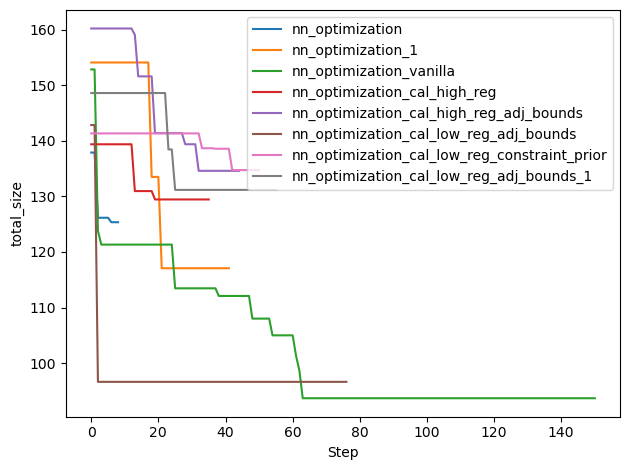

In [7]:
fig, ax = plt.subplots(1, 1)

for filename in bo_files:
    with open(filename) as f:
        d = yaml.safe_load(f)
    df = pd.DataFrame(d["data"])
    data = df.dropna()

    # calculate running minimum
    running_min = []
    for i in range(len(data)):
        running_min.append(data["total_size"].iloc[:i+1].min())

    ax.plot(running_min, label=os.path.basename(filename)[:-4])

ax.set_xlabel("Step")
ax.set_ylabel("total_size")
ax.legend()
fig.tight_layout()

## Load NN Prior Model

In [8]:
model_path = "lcls_cu_injector_nn_model/"

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=list(vocs["variables"].keys()),
    output_order=lume_model.outputs[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        # return torch.sqrt(torch.abs(sigma_x) * torch.abs(sigma_y))
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

## Load Calibrated NN Prior Models

In [9]:
calibration_path = "../nn_prior/calibration/"

regs, cal_models = ["low", "high"], []
for reg in regs:
    # load nn_to_cal transformers
    input_nn_to_cal = torch.load(calibration_path + f"input_nn_to_cal_{reg}_reg.pt")
    output_nn_to_cal = torch.load(calibration_path + f"output_nn_to_cal_{reg}_reg.pt")
    
    # create LUME-model
    cal_lume_model = PyTorchModel(
        model_file=model_path + "model/model.pt",
        input_variables=input_variables,
        output_variables=output_variables,
        input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
        output_transformers=[output_nn_to_cal, output_sim_to_nn, output_pv_to_sim],
    )
    
    # wrap in LUMEModule
    cal_lume_module = LUMEModule(
        model=cal_lume_model,
        feature_order=list(vocs["variables"].keys()),
        output_order=cal_lume_model.outputs[0:2],
    )
    
    cal_models.append(ObjectiveModel(cal_lume_module))

## Calculate Correlations and MAEs

In [10]:
# define calculation of correlation
def calc_corr(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    corr = torch.corrcoef(torch.stack([a.squeeze(), b.squeeze()]))
    return corr[0, 1]

In [11]:
# define calculation of MAE
def calc_mae(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.l1_loss(a, b)

In [12]:
metrics = pd.DataFrame(columns=[["All Data"] * 2 + ["BO"] * 2 + ["BE"] * 2, ["Corr", "MAE"] * 3])
for model in [objective_model] + cal_models:
    model_metrics = []
    for df_data in [df, df_bo, df_be]:
        
        # get valid inputs and outputs
        data = df_data.dropna()
        x = torch.from_numpy(data[lume_module.feature_order].to_numpy())
        y = torch.from_numpy(data[list(vocs["objectives"].keys())[0]].to_numpy())
        
        # predictions
        pred = model(x)
        
        # get model metrics
        model_metrics.append("{:.2f}".format(calc_corr(pred, y).item()))
        model_metrics.append("{:.2f}".format(calc_mae(pred, y).item()))

    metrics.loc[len(metrics.index)] = model_metrics
metrics.index = ["Original Model", "Calibrated (Low Reg)", "Calibrated (High Reg)"]

In [13]:
metrics

All Data            BO            BE        
                          Corr     MAE  Corr     MAE  Corr     MAE
Original Model            0.06  218.81  0.35  186.05  0.25  404.98
Calibrated (Low Reg)      0.31  279.48  0.52  396.74  0.53  443.41
Calibrated (High Reg)     0.39  156.97  0.50  190.84  0.43  198.55